# Deep Learning for Term Structure Forecasting
## Data Analysis
#### David Koubek

Model_fit.R all code below

In [1]:
# Master Thesis
# Model fitting follows
# v1.2 - converting the environment/code for cuDNN LSTM GPU training (WIP)

rm(list = ls())

In [3]:
# Bind R to a Python environment that has TensorFlow with GPU support
# Do this first before loading any further packages, otherwise the R session can be binded with a default CPU environment and you will have to restart R to rebind
# reticulate::use_condaenv("r-tensorflow-gpu") # Specify the name of a conda environment.
# reticulate::use_condaenv("r-tensorflow-gpu", required = TRUE)
# play:
# reticulate::repl_python()
# import tensorflow as tf

# Packages
if (!require("pacman")) install.packages("pacman") # installs pacman package if not installed yet

Loading required package: pacman
Warning message:
"package 'pacman' was built under R version 3.6.3"

pacman::p_load(pacman, dplyr, tidyr, ggplot2, scales, Cairo, zoo, xtable, tibble, forecast, naturalsort) # load packages TBD e.g. these, edit when u determine which needed/used..
p_load(reticulate, tensorflow, keras)
py_config()
tf_config()
# devtools::session_info()

In [4]:
# Workspace
# setwd("E:/Google_Drive/Diploma_Thesis/Code")
setwd("I:/Diploma_Thesis/Code")
# load(file = "Workspaces/Data_03_trimmed-small_US.RData") # 0min
load(file = "Workspaces/Data_04_split-small_US_tick_05-2019.RData") # 0min
print("Workspace rdy set go!")

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


[1] "Workspace rdy set go!"


In [7]:
#############################
###### Split datasets #######
#############################

# Picks the future
futurenames # shall contain US and EU various maturities eventually
future <- 1
futurenames[future]

[1] "US"

[1] "US"

In [35]:
# Train and test split
# dataFutures_tmp <- data_small_aday$Close # one day of data, 24k obs
dataFutures_tmp <- data_small_amonth$Close # one month of data, 780k obs
(end <- length(dataFutures_tmp))
(split_train <- round(3/5 * end))
(split_val <- round(4/5 * end))

dataFutures_train <- dataFutures_tmp[1:split_train]
dataFutures_val <- dataFutures_tmp[(split_train + 1):split_val]
dataFutures_test <- dataFutures_tmp[(split_val + 1):end]

# Differencing the data - optional, but better results
dataFutures_train_orig <- dataFutures_train # backup of original data for the end "undiff"
dataFutures_val_orig <- dataFutures_val
dataFutures_test_orig <- dataFutures_test

dataFutures_train <- diff(dataFutures_train)
dataFutures_val <- diff(dataFutures_val)
dataFutures_test <- diff(dataFutures_test)
summary(dataFutures_train)

[1] 780735

[1] 468441

[1] 624588

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.1250000  0.0000000  0.0000000  0.0000044  0.0000000  0.5625000 

In [36]:
summary(dataFutures_train != 0)

   Mode   FALSE    TRUE 
logical  445208   23232 

In [37]:
timpy <- dataFutures_train[dataFutures_train != 0]
str(timpy)
summary(timpy)

 num [1:23232] -0.0312 0.0312 -0.0312 0.0312 -0.0312 ...


      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.1250000 -0.0312500  0.0312500  0.0000888  0.0312500  0.5625000 

In [41]:
install.packages("HistogramTools")
library(HistogramTools)

Warning message:
"package 'HistogramTools' is in use and will not be installed"

In [44]:
myhist <- HistogramTools:::.BuildHistogram(timpy)
plot(myhist)

ERROR: Error in stopifnot(is.numeric(breaks), is.numeric(counts)): argument "counts" is missing, with no default


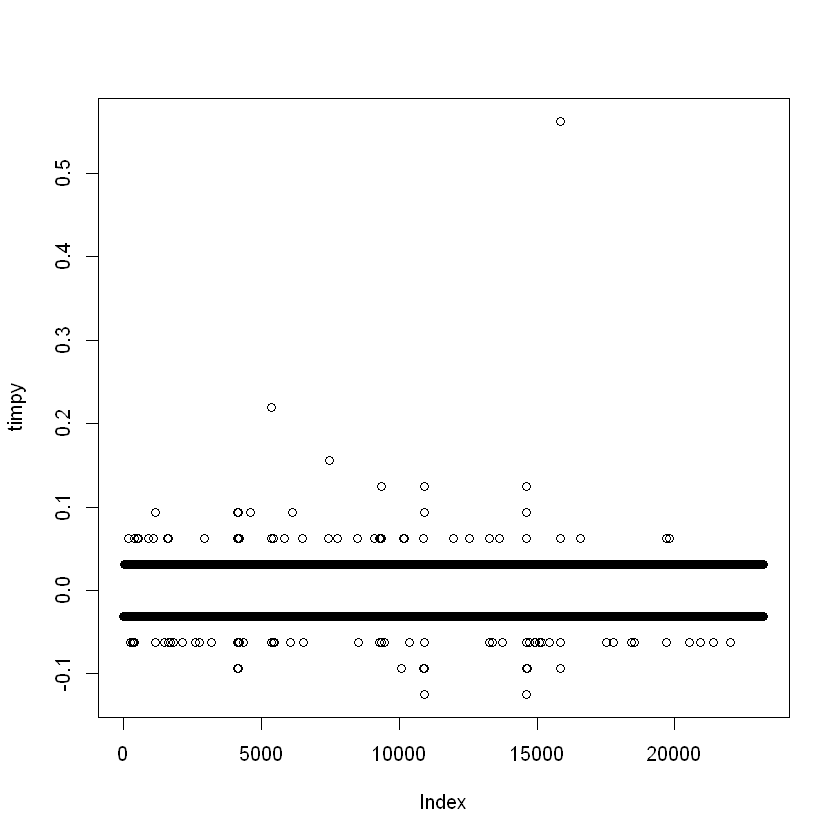

In [38]:
plot(timpy)

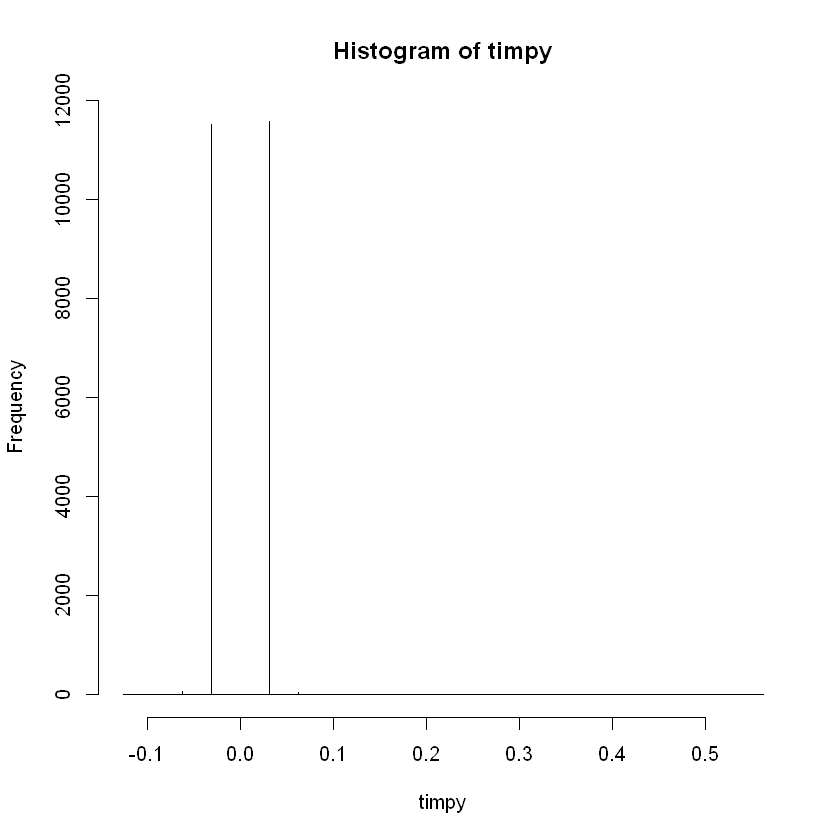

In [39]:
hist(timpy, breaks = 20000)

#############################
###### Graph datasets #######
#############################

# Graph of the split original dataset
	data_df <- data_frame(time = 1:(length(dataFutures_train_orig) + length(dataFutures_val_orig) + length(dataFutures_test_orig)),
	                 	  train = c(dataFutures_train_orig, rep(NA, length(dataFutures_val_orig) + length(dataFutures_test_orig))),
	                 	  val = c(rep(NA, length(dataFutures_train_orig)), dataFutures_val_orig, rep(NA, length(dataFutures_test_orig))),
	                 	  test = c(rep(NA, length(dataFutures_train_orig) + length(dataFutures_val_orig)), dataFutures_test_orig))
	data_df <- data_df %>% gather(key = 'train_val_test', value = 'value', -time) # -time

	custom_scale <- 1.5 # for the graph to look nice, sizes of graph items and fonts
	dataset_graph <- ggplot(data_df, aes(x = time, y = value, color = train_val_test)) +
		geom_line() +
		labs(x = "obs", y = "price") +
		# scale_x_continuous(breaks = c(1, round(seq(20000, end - 3, by = 20000), 1), split_train - 1, split_val - 2, end - 3)) +
		# scale_x_continuous(breaks = pretty_breaks(5)) +
		scale_colour_discrete(name = "Dataset", breaks = c("train", "val", "test"), labels = c("train", "validate", "test")) +
		guides(colour = guide_legend(override.aes = list(size = 4/3 * custom_scale))) +
		theme_bw(base_family = "LM Roman 10", base_size = 16 * custom_scale) +
		theme(legend.key.height = unit(1 * custom_scale, "lines"))
		# theme(legend.key.height = unit(1 * custom_scale, "lines"), axis.text.x = element_text(angle = 35, vjust = 0.8))
	dataset_graph

# Graph of the split differenced dataset
	data_df <- data_frame(time = 1:(length(dataFutures_train) + length(dataFutures_val) + length(dataFutures_test)),
	                 	  train = c(dataFutures_train, rep(NA, length(dataFutures_val) + length(dataFutures_test))),
	                 	  val = c(rep(NA, length(dataFutures_train)), dataFutures_val, rep(NA, length(dataFutures_test))),
	                 	  test = c(rep(NA, length(dataFutures_train) + length(dataFutures_val)), dataFutures_test))

	data_df <- data_df %>% gather(key = 'train_val_test', value = 'value', -time) # -time

	custom_scale <- 1.5 # for the graph to look nice, sizes of graph items and fonts
	split_graph <- ggplot(data_df, aes(x = time, y = value, color = train_val_test)) +
		geom_line() +
		labs(x = "obs", y = "price difference") +
		# scale_x_continuous(breaks = c(1, round(seq(20000, end - 3, by = 20000), 1), split_train - 1, split_val - 2, end - 3)) +
		# scale_x_continuous(breaks = pretty_breaks(5)) +
		scale_colour_discrete(name = "Dataset", breaks = c("train", "val", "test"), labels = c("train", "validate", "test")) +
		guides(colour = guide_legend(override.aes = list(size = 4/3 * custom_scale))) +
		theme_bw(base_family = "LM Roman 10", base_size = 16 * custom_scale) +
		theme(legend.key.height = unit(1 * custom_scale, "lines"))
		# theme(legend.key.height = unit(1 * custom_scale, "lines"), axis.text.x = element_text(angle = 35, vjust = 0.8))
	split_graph

# Save the graphs to file
	GoldenRatio <- (1 + sqrt(5)) / 2
	# plots_width <- 5.55226 # width in inches of thesis template textwidth
	plots_width <- 10 * custom_scale # 10 inches plus have nicely smallish graph elements, adjust custom scale for each graph type what looks nice
	plots_height <- plots_width / GoldenRatio

# A day
	# ggsave(dataset_graph, filename = paste0("Graphs/dataset_", futurenames[future], "_aday.pdf"), device = cairo_pdf,
	# 	width = plots_width, height = plots_height, units = "in")
	# ggsave(split_graph, filename = paste0("Graphs/differenced_", futurenames[future], "_aday.pdf"), device = cairo_pdf,
	# 	width = plots_width, height = plots_height, units = "in")

# A month
	ggsave(dataset_graph, filename = paste0("Graphs/dataset_", futurenames[future], "_amonth.pdf"), device = cairo_pdf,
		width = plots_width, height = plots_height, units = "in")
	ggsave(split_graph, filename = paste0("Graphs/differenced_", futurenames[future], "_amonth.pdf"), device = cairo_pdf,
		width = plots_width, height = plots_height, units = "in")


# Save workspace
# save.image(file = paste0("Workspaces/Data_04_split-small_", futurenames[future], "_tick_05-2019.RData")) # 1min 21MB




#############################
#### TBD Factor models ######
#############################

# Not programmed yet, shall run the data through the factor models (DNS) before training the NNs.
# In a separate script probably, Model_factor.R
# Run script.




#############################
########## ANNs #############
#############################

ls()

### Prepare parameters ###

# Windowing the data
lstm_num_timesteps <- 4
# lstm_num_timesteps <- 12

window_data <- function(data) { # window the input data
	t(sapply(1:(length(data) - lstm_num_timesteps), function(x) data[x:(x + lstm_num_timesteps - 1)]))
}

data_train <- window_data(dataFutures_train)
data_val <- window_data(dataFutures_val)
data_test <- window_data(dataFutures_test)
data_train[1:5, 1:4]

window_labels <- function(data) { # window the labels data
	sapply((lstm_num_timesteps + 1):(length(data)), function(x) data[x])
}

labels_train <- window_labels(dataFutures_train)
labels_val <- window_labels(dataFutures_val)
labels_test <- window_labels(dataFutures_test)
labels_train[1:5]


# Keras LSTMs expect the input array to be shaped as (no. samples, no. time steps, no. features), yet we have just the two axes, need to add an axis "no.features" at the end that will just say that we have 1 feature (we have just one column/price to feed)
# dim(data_train)
# dim(data_val)
# dim(data_test)
# K <- backend() # don't need this approach anymore, from Keras 2.1.2 can use k_expand_dims and k_eval
# data_train <- K$eval(K$expand_dims(data_train, axis = 2L)) # 2L because of this https://github.com/rstudio/tensorflow/issues/190
data_train <- k_eval(k_expand_dims(data_train, axis = -1)) # -1 for the last axis to expand at
data_val <- k_eval(k_expand_dims(data_val, axis = -1))
data_test <- k_eval(k_expand_dims(data_test, axis = -1))
dim(data_train)
str(data_train)
class(data_train)


# LSTM input shape: (samples, time steps, features)
num_samples <- dim(data_train)[1]
num_steps <- dim(data_train)[2]
num_features <- dim(data_train)[3]
c(num_samples, num_steps, num_features)



#############################
####### Training NNs ########
#############################

# TensorBoard initialisation/stopping
# dir.create("TensorBoard_logs")
tensorboard(log_dir = "TensorBoard_logs/tmp", host = "127.0.0.1", port = "1001", launch_browser = utils::browseURL("http://127.0.0.1:1001"), reload_interval = 5) # Launch TensorBoard and wait for output in specified directory
# tensorboard(log_dir = "TensorBoard_logs", host = "127.0.0.1", port = "1001", reload_interval = 5) # Launch TensorBoard manually at http://127.0.0.1:1001 and wait for output in specified directory
tensorboard(log_dir = "TensorBoard_logs/tmp", action = "stop") # stops the TensorBoard
# browseURL("http://127.0.0.1:1001") # launches the TensorBoard url

##### TBD Tune #####
# Define manually parameters here that will be used in the model
### MAE ###
	n_epochs <- 5 # for now 50 takes 10min for smallest network, later obviously need to train longer to optimise until it starts overfitting
	batch <- 128

	parameters_architecture <- list(nlayers = 1, units = c(8, 0, 0), dropout = 0.2, recurrent_dropout = 0.2) # 11s per epoch on a month of data
	parameters_compile <- list(loss = "mae", optimizer = "rmsprop", metrics = "mse") ### for MAE ###
	# parameters_compile <- list(loss = "mse", optimizer = "rmsprop", metrics = "mae") ### for MSE trials ###
	parameters_fit <- list(epochs = n_epochs, batch_size = batch)
	parameters_1 <- c(parameters_architecture, parameters_compile, parameters_fit)

	parameters_architecture <- list(nlayers = 1, units = c(32, 0, 0), dropout = 0.2, recurrent_dropout = 0.2)
	# parameters_fit <- list(epochs = n_epochs, batch_size = batch) # if we want to change sth
	parameters_2 <- c(parameters_architecture, parameters_compile, parameters_fit)

	parameters_architecture <- list(nlayers = 2, units = c(8, 16, 0), dropout = 0.1, recurrent_dropout = 0.5)
	parameters_3 <- c(parameters_architecture, parameters_compile, parameters_fit)

	parameters_architecture <- list(nlayers = 2, units = c(32, 64, 0), dropout = 0.1, recurrent_dropout = 0.5)
	parameters_4 <- c(parameters_architecture, parameters_compile, parameters_fit)

	parameters_architecture <- list(nlayers = 3, units = c(32, 64, 128), dropout = 0.1, recurrent_dropout = 0.5) # 43s per epoch
	parameters_5 <- c(parameters_architecture, parameters_compile, parameters_fit)

	parameters <- list(NN_1L_6N = parameters_1, NN_1L_32N = parameters_2,
					   NN_2L_6N12N = parameters_3, NN_2L_32N64N = parameters_4,
					   NN_3L_32N32N64N = parameters_5)
	str(parameters)

# Keras LSTM model
# Looping the layers to automate it
build_model_n <- function(nlayers = 1, units = rep(6, nlayers), dropout = 0, recurrent_dropout = 0,
						  loss = "mae", optimizer = "rmsprop", metrics = "mse", ...) {
	k_clear_session() # clearing the model/session first with backend to avoid TensorBoard errors
	
	model <- keras_model_sequential()
	for (i in 1:nlayers) { # hidden layers
		# model %>% layer_cudnn_lstm(units = units[i], return_sequences = (i != nlayers), input_shape = c(num_steps, num_features))
		# AttributeError: module 'tensorflow_core.keras.layers' has no attribute 'CuDNNLSTM'
		model %>% layer_lstm(units = units[i], return_sequences = (i != nlayers), dropout = dropout, recurrent_dropout = recurrent_dropout, input_shape = c(num_steps, num_features))
	}
	model %>% layer_dense(units = 1) # output layer

	model %>% compile(
		loss = loss,
		optimizer = optimizer,
		metrics = metrics
	)
}

save <- function(what, name) {
	save_model_hdf5(what, paste0("Models/tmp/Model_", name, ".h5"))
	save.image(file = paste0("Workspaces/tmp/Image_", name, "_trained.RData"))
}


# model_names <- c()
len <- 1
# for (i in 1:len) {
	i <- 1 # number of the run
	print(paste("Iteration", i, "/", len))
	for (hyp_tune in 1:1) { # 1:5 or 1:(length(parameters)
		hyp_tune <- 1 # in case u want to skip the for loop and manually select which one to train
		print(paste("Hyperparameter tuning", hyp_tune, "/", length(parameters)))

		model <- do.call(what = build_model_n, args = parameters[[hyp_tune]])
		print(model)

		layers_name <- c()
		for (j in 1:parameters[[hyp_tune]]$nlayers) {layers_name <- paste0(layers_name, model$layers[[j]]$units, "N-")}
		model_name <- paste0(futurenames[future], "-1H-2003-2017-LSTM-k", lstm_num_timesteps, "-", length(model$layers) - 1, "L-", layers_name,
							  100 * model$layers[[1]]$dropout, "pDr-", 100 * model$layers[[1]]$recurrent_dropout, "pRDr-",
							  toupper(model$loss),"-", parameters_compile$optimizer, "-", toupper(model$metrics_names[2]),"-", parameters[[hyp_tune]]$epochs, "E_run_", i)
		print(paste("Training model", model_name))

		# dir.create("TensorBoard_logs", showWarnings = FALSE)
		log_run_dir <- paste0("TensorBoard_logs/tmp/", model_name)
		model_checkpoint_dir <- paste0("Models/checkpoints/", model_name)
		dir.create(model_checkpoint_dir, showWarnings = FALSE, recursive = TRUE)
		model_checkpoint_name <- "/{epoch:02d}E-{val_loss:.5f}vloss.hdf5"

		callbacks_list = list(
			callback_tensorboard(
				log_dir = log_run_dir,
				histogram_freq = 1 # Records activation histograms every 1 epoch
				# embeddings_freq = 1 # Records embedding data every 1 epoch
			),
			# callback_early_stopping(
			# 	monitor = "val_loss",
			# 	patience = 100
			# ),
			callback_model_checkpoint(
				filepath = paste0(model_checkpoint_dir, "/", model_checkpoint_name),
				monitor = "val_loss"
				# save_best_only = TRUE # uncomment if u want to checkpoint only the best models, but when it's commented out, all models will be written (provided the model_checkpoint_dir name for each model varies w/ next epoch..)
			)
		)

		history <- model %>% fit(
			data_train, labels_train,
			epochs = parameters[[hyp_tune]]$epochs, batch_size = parameters[[hyp_tune]]$batch_size, # batch_size = 128, epochs = 500 for real run; epochs = i*ep for increasing number of epochs w/ iterations
			validation_data = list(data_val, labels_val), # computes loss and accuracy for validation data after every epoch
			# validation_split = 0.2,
			callbacks = callbacks_list, # for TensorBoard logging
			# initial_epoch = 100, # TBD try, integer, Epoch at which to start training (useful for resuming a previous training run).
			verbose = 2
		)

		# dir.create("Workspaces/runs", showWarnings = FALSE, recursive = TRUE)
		save(what = model, name = model_name)
	}
# }

plot(history)


#####################
####### Notes #######
#####################

# TBD:
	# extensive hyperpar tuning once the code is scalable